---
title: "Reproducing Cui Xiang-Han et. al (2020)'s 'Fast radio bursts: do repeaters and non-repeaters originate in statistically similar ensembles?'"
subtitle: Is it possible that repeaters and non-repeaters have different mechanisms?
author: Murthadza Aznam
date: '2022-12-26'

---

:::{.callout-note}

 📌 Goal: This notebook tries to reproduce the results from [https://ui.adsabs.harvard.edu/abs/2021MNRAS.500.3275C/abstract](https://ui.adsabs.harvard.edu/abs/2021MNRAS.500.3275C/abstract). As stated in the paper, verbatim 
 
 > We investigate the statistical classifications for the two groups of samples **to see if the non-repeating and repeating FRBs have different origins** by employing Anderson–Darling (A–D) test and Mann–WhitneyWilcoxon (M–W–W) test

:::

In [1]:
#| echo: false
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

## 0. Getting The Data

### 0.1 Source
The data underlying said article are available in the references below: 

1. Spitler et al. ([2016](https://www.nature.com/articles/nature17168)); 
2. CHIME/FRB Collaboration ([2019a](https://www.nature.com/articles/s41586-018-0864-x));
3. Kumar et al. ([2019](https://iopscience.iop.org/article/10.3847/2041-8213/ab5b08));
4. CHIME/FRB Collaboration ([2019b](https://iopscience.iop.org/article/10.3847/2041-8213/ab4a80));
5. Fonseca et al. ([2020](https://iopscience.iop.org/article/10.3847/2041-8213/ab7208)). 

Some data of FRBs are taken from the data base of FRBCAT, available at http://www.frbcat.org/.


#### 0.1.1 Non-Repeaters
However, I have not been able to effectively filter out repeater from the whole population in the FRBCAT Database so I used the FRBSTATS^[https://www.herta-experiment.org/frbstats/] as a proxy with the described filters:

- `width` <= 35
- is not identified as `repeater`
- The FRB is observed between FRBCAT's minimum dan maximum `utc` datetime   
- `telescope` is also available in the FRBCAT catalogue, except 'CHIME/FRB'^[Even with the described filters, the CHIME/FRB telescope dominates the dataset making up >500 data points while it is not that prominent in FBRCAT and also the total data points is less than 100]

Using the described filters, I have been able to obtain 88 data points.
It is close to the papers sample of 80 ~ 91^[The paper mentioned both numbers. The lower limit of 80 is mentioned in the conclusion but the upper limit of 91 is mentioned in the abstract. So I took it as a range instead.]

In [ ]:
# Load FRBCAT Catalogue (to be used in some filters)

frbcat = pd.read_csv("../data/raw/external/frbcat_20221227.csv", parse_dates=['utc'])

frbcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   frb_name      129 non-null    object        
 1   utc           129 non-null    datetime64[ns]
 2   telescope     129 non-null    object        
 3   rop_raj       129 non-null    object        
 4   rop_decj      129 non-null    object        
 5   rop_gl        129 non-null    float64       
 6   rop_gb        129 non-null    float64       
 7   rmp_dm        129 non-null    float64       
 8   rmp_dm_error  124 non-null    float64       
 9   rmp_width     129 non-null    float64       
 10  rmp_snr       127 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 11.2+ KB


In [ ]:
# Load FRBSTATS catalogue and do appropriate filter

# A separate list is used because FRBCAT uses a different name
frbstats_telescope_names_available_in_frbcat = ['Parkes', 'Arecibo', 'Pushchino', 'FAST', 'DSA', 'CHIME', 'WSRT/Apertif', 'UTMOST', 'VLA', 'GBT', 'ASKAP']
frbstats_float_columns = ['l', 'b', 'frequency', 'dm', 'flux', 'width', 'fluence', 'snr', 'redshift']

repeaters_samples = pd.read_csv('../data/raw/external/FRBSTATS2022-11-23_repeaters.csv', index_col=0)
frbstats = pd.read_csv('../data/raw/external/FRBSTATS2022-11-23_population.csv', 
    parse_dates=['utc'], 
    dtype={telescope: float for telescope in frbstats_telescope_names_available_in_frbcat},
    na_values=["-"]
    )
# Label repeaters
frbstats["repeater"] = False
frbstats.loc[frbstats["frb"].isin(repeaters_samples["samples"]),"repeater"] = True

selected_data = frbstats[
    (frbstats['repeater'] == False) & 
    (frbstats["width"] <= 35) &
    (frbstats["telescope"].isin(frbstats_telescope_names_available_in_frbcat)) &
    (frbstats['telescope'] != 'CHIME') &
    (frbstats["utc"].between(frbcat["utc"].min(), frbcat["utc"].max()))
    ]

selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 4 to 765
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   frb                88 non-null     object        
 1   utc                88 non-null     datetime64[ns]
 2   mjd                88 non-null     float64       
 3   telescope          88 non-null     object        
 4   ra                 88 non-null     object        
 5   dec                88 non-null     object        
 6   l                  88 non-null     float64       
 7   b                  88 non-null     float64       
 8   frequency          88 non-null     float64       
 9   dm                 88 non-null     float64       
 10  flux               74 non-null     float64       
 11  width              88 non-null     float64       
 12  fluence            85 non-null     float64       
 13  snr                86 non-null     float64       
 14  reference  

In order the accept that both these data describe the same sample, I plotted the overlap between our selected data and the original FRBCAT data.
Note that, 
1. the FRBCAT is not filtered out so it may contain repeaters or not, and
2. CHIME/FRB data is deliberately excluded in the FRBSTATS source

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16520\2803677944.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frbstats_.loc[:, ['source']] = 'frbstats'


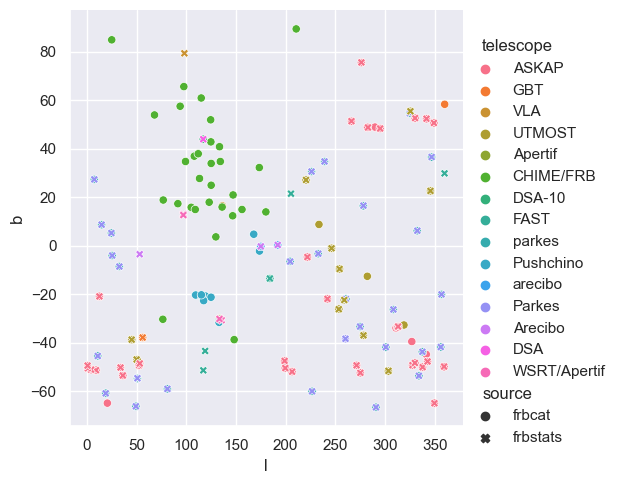

In [ ]:
frbcat_ = frbcat.rename(columns={'frb_name':'frb','rop_raj': 'ra', 'rop_decj': 'dec', 'rop_gb': 'b', 'rop_gl': 'l', 'rmp_width': 'width', 'rmp_dm': 'dm', 'rmp_snr': 'snr'})
frbcat_.loc[:, ['source']] = 'frbcat'
frbstats_ = selected_data[['frb', 'utc', 'telescope', 'ra', 'dec', 'l', 'b', 'dm', 'width', 'snr']]
frbstats_.loc[:, ['source']] = 'frbstats'
frbpopulation_merged = pd.concat([frbcat_, frbstats_])

sns.relplot(data=frbpopulation_merged, x='l', y='b', style='source', hue='telescope')

#### 0.1.2 Repeaters

Data on repeaters are easy to obtain. 
The authors are kind enough to provide table on all 20 samples used in the study.

![](xiang-han2020-table1.png)

In [ ]:
xianghan = pd.read_csv('../data/raw/external/XiangHan2020_ensemble-repeaters.csv')

In [ ]:
#| echo: false
from IPython.display import Markdown

Markdown(xianghan.to_markdown())

|    |   No. | Sources            |   Observed width (ms) |   Intrinsic width (ms) |   Flux density (Jy) |   Fluence (Jy ms) |   Distance (Gpc) |  Refs.   |
|---:|------:|:-------------------|----------------------:|-----------------------:|--------------------:|------------------:|-----------------:|:---------|
|  0 |     1 | FRB121102          |                  4.82 |                   4.78 |                0.25 |             0.372 |             1.61 | (1)      |
|  1 |     2 | FRB180814.J0422+73 |                 23.45 |                  23.43 |              nan    |            22.57  |             0.39 | (2)(3)   |
|  2 |     3 | FRB171019          |                  4.62 |                   4.08 |              nan    |           101.54  |             1.89 | (4)      |
|  3 |     4 | FRB180916.J0158+65 |                  5.27 |                   5.16 |                2.08 |             1.62  |             0.58 | (5)      |
|  4 |     5 | FRB181030.J1054+73 |                  1.01 |                   0.1  |                3.15 |             4.75  |             0.24 | (5)      |
|  5 |     6 | FRB181128.J0456+63 |                  5.9  |                   5.8  |                0.4  |             3.45  |             1.14 | (5)      |
|  6 |     7 | FRB181119.J12+65   |                  3.49 |                   3.33 |                0.43 |             1.77  |             1.42 | (5)      |
|  7 |     8 | FRB190116.J1249+27 |                  2.75 |                   2.53 |                0.35 |             1.8   |             1.9  | (5)      |
|  8 |     9 | FRB181017.J1705+68 |                 16.8  |                  16.73 |                0.4  |             8.5   |             6.97 | (5)      |
|  9 |    10 | FRB190209.J0937+77 |                  6.55 |                   6.46 |                0.5  |             1.25  |             1.66 | (5)      |
| 10 |    11 | FRB190222.J2052+69 |                  2.71 |                   2.48 |                1.65 |             5.45  |             1.64 | (5)      |
| 11 |    12 | FRB190208.J1855+46 |                  1.11 |                   0.14 |                0.5  |             1.7   |             2.35 | (6)      |
| 12 |    13 | FRB180908.J1232+74 |                  3.83 |                   3.7  |                2.9  |             0.5   |             0.62 | (6)      |
| 13 |    14 | FRB190604.J1435+53 |                  2.1  |                   1.78 |                0.75 |             8.3   |             2.42 | (6)      |
| 14 |    15 | FRB190212.J18+81   |                  3.1  |                   2.93 |                0.75 |             2.75  |             1.05 | (6)      |
| 15 |    16 | FRB190303.J1353+48 |                  3.2  |                   3.04 |                0.47 |             2.67  |             0.77 | (6)      |
| 16 |    17 | FRB190417.J1939+59 |                  4.5  |                   4.2  |                0.53 |             3.1   |             7.4  | (6)      |
| 17 |    18 | FRB190117.J2207+17 |                  2.74 |                   2.53 |                1    |             6.36  |             1.49 | (6)      |
| 18 |    19 | FRB190213.J02+20   |                  7    |                   6.9  |                0.5  |             1.8   |             2.91 | (6)      |
| 19 |    20 | FRB190907.J08+46   |                  2.18 |                   1.92 |                0.3  |             2.03  |             1.07 | (6)      |

## 1.0 Preprocessing

### 1.1 Parameters
1. Pulse width
2. Radio Luminosity


Our data of FRBs are taken from the data base of FRB Catalogue, and those for repeating FRBs come from FRBCAT and published papers (mentioned above). 

According to FRBCAT, there is a significant gap between ∼35 and ∼300 ms in pulse width. 
However, we notice that the measurements with pulse width larger than ∼300 ms all come from one radio facility, i.e. the radio telescope BSA LPI of the Pushchino Radio Astronomy Observatory, in which the time interval between samples is 100 ms (Fedorova & Rodin 2019). 
Considering that there may exist some observational bias effects in these data, we only include the pulses with a width shorter than ∼35 ms (80 non-repeaters). 
For non-repeating FRBs, the possibility of repetition cannot be rejected; in particular, repeating signals from FRB171019 have been observed (Kumar et al. 2019) in 2019. 
However, our analysis is based on the current observational data, and the phenomenon of repeating signals in non-repeaters is difficult to predict at present. 
Therefore, we treat the apparently non-repeating sources as real non-repeaters under current circumstances. 
For repeating FRBs, two or more observations are included. 
Thus, we calculate the average pulse width and radio luminosity of each source as representative of its pulse width and radio luminosity, respectively. 
Since the pulse width in the FRBCAT is the observed width, which is easily affected by dispersion, to study the pulse width more accurately, we need to introduce the intrinsic width that is estimated by equation:
$$
t_i = \sqrt{t^2_\text{obs} − t^2_\text{DM} − t^2_s}
$$
In the above formula, $t_i(t_\text{obs})$ is the intrinsic width (observed width), with $t_s$ being the sampling time that depends on the instrument, and $t_\text{DM}$ is the dispersion smearing time-scale as calculated in the following: 
$$
t_\text{DM} = 8.3 \times 10^{−3} \text{DM}\frac{\Delta ν_\text{MHz}}{ν^3_\text{GHz}} ms,
$$
where DM is the dispersion measure, $\Delta ν_\text{MHz}$ is the channel bandwidth in the unit of MHz, and $ν_\text{GHz}$ is the central frequency in the unit of GHz. 
Therefore, the pulse width in the following text represents the intrinsic width. 
In Table 1, we summarize the properties of 20 repeating FRBs, by listing the observed width, intrinsic width, flux density, fluence, and luminosity distance.